# Libraries

In [952]:
import numpy as np
import sympy as sp
import sympy.physics.quantum as sq
import sympy.physics.quantum.qubit as sqq
import sympy.physics.quantum.gate as sqg

import cvxpy as cp

import matplotlib.pyplot as plt
import networkx as nx

sp.init_printing(use_latex='mathjax')
from IPython.display import display


import pickle
import dill
dill.settings['recurse'] = True


#for pretty printing of matrices
import pandas as pd

## idealFid

In [953]:
class idealFid:
    
    def __init__(s):
        P1 = s.proj(1,5)
        P2 = s.proj(2,5)
        P3 = s.proj(3,5)
        P4 = s.proj(4,5)
        P5 = s.proj(5,5)
        s.P = [P1,P2,P3,P4,P5]
        s.terms = 5

    def proj(s,j,n):
        pi=np.pi
        temp1 = np.cos(pi/n)/(1+np.cos(pi/n))
        temp2 = 1-temp1
        temp3 = j*pi*(n-1)/n
        vec = np.asarray([np.sqrt(temp1),np.sqrt(temp2)*np.sin(temp3), np.sqrt(temp2)*np.cos(temp3)])
        mat = np.outer(vec,vec)
        return mat
    
    
    def idealVal(s,projList):
        op = s.P[projList[0]]
        for iProj in projList[1:]:
            op = op@s.P[iProj]
        return op[0,0]
    

## Extending the braket library to include orthogonality

In [954]:
class onStruct:
    G = nx.Graph()

class onKet(sq.Ket,onStruct):
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        elif sq.Dagger(bra) in G[self]:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    
    @classmethod
    def set_on_rel(cls,givenG):
        cls.G=givenG
    
    @classmethod
    def dual_class(self):
        return onBra

    
class onBra(sq.Bra,onStruct):
    @classmethod
    def dual_class(self):
        return onKet

In [955]:
class bKet(sq.Ket):
    
    #total number of kets (automatically increases as new instances are initialised)
    totalKets=0
    
    #this method automates the increase
    @classmethod
    def _eval_args(cls,args):
        #validate input type
        if not isinstance(args[0],int):
            raise ValueError("Integer expected in the argument, got: %r"%args[0])

        #if a ket |5> is initialised, the dimension is assumed to be 6 since we have |0>,|1>,...|5>
        if int(args[0])+1 > cls.totalKets:
            cls.totalKets=args[0]+1
        
        #pass control back to the base class
        return sq.Ket._eval_args(args) 
    
    #Could not find a way of using just one function; need to go through the two
    #based on a combination of the qubit implementation and the 
    def _represent_default_basis(s,**options):
        return s._represent_bKet(None,**options) #syntax taken from the Qubit library
    
    def _represent_bKet(s,basis,**options): #_represent_default_basis
        a=np.zeros(s.__class__.totalKets,dtype=int)
        a[s.label[0]]=1
        return sp.Matrix(a)
    
    @classmethod
    def set_dimension(cls,arg):
        cls.totalKets=arg
    
    def _eval_innerproduct(self,bra,**hints):
        #Check if the innerproduct is with yourself, then set 1
        if sq.Dagger(bra) == self:
            return sp.Integer(1)
        #Else, if the innerproduct is with a neighbor from the graph, set 0
        else:
            return sp.Integer(0)
        #Else, do nothing; not enough information
    

    @classmethod
    def dual_class(self):
        return bBra

    
class bBra(sq.Bra):
    # @classmethod
    # def _eval_args(cls,args):
    #     return args
    
    @classmethod
    def dual_class(cls):
        return bKet

### Debugging | representation example

In [ ]:
class SzUpKet(sq.Ket):
    def _represent_SzUpKet(s,basis,**options):
        return sp.Matrix([1,0])
    
#     def _represent_SzOp(s,basis,**options):
#         return sp.Matrix([1,0])

class SzOp(sq.Operator):
    pass

sz = SzOp('Sz')
up = SzUpKet('up')
sq.represent(up,basis=SzUpKet) #,basis=sz)

### Testing | Dimension increasing?

In [ ]:
# class bKet(sq.Ket):
    
#     #total number of kets (automatically increases as new instances are initialised)
#     totalKets=0
    
#     #this method automates the increase
#     @classmethod
#     def _eval_args(cls,args):
#         #validate input type
#         if not isinstance(args[0],int):
#             raise ValueError("Integer expected in the argument, got: %r"%args[0])

#         #if a ket |5> is initialised, the dimension is assumed to be 6 since we have |0>,|1>,...|5>
#         if int(args[0])+1 > cls.totalKets:
#             cls.totalKets=args[0]+1
        
#         #pass control back to the base class
#         return sq.Ket._eval_args(args) 
    
#     #Could not find a way of using just one function; need to go through the two
#     #based on a combination of the qubit implementation and the 
#     def _represent_default_basis(s,**options):
#         return s._represent_bKet(None,**options) #syntax taken from the Qubit library
    
#     def _represent_bKet(s,basis,**options): #_represent_default_basis
#         a=np.zeros(s.__class__.totalKets,dtype=int)
#         a[s.label[0]]=1
#         return sp.Matrix(a)
    
#     @classmethod
#     def set_dimension(cls,arg):
#         cls.totalKets=arg
    
#     def _eval_innerproduct(self,bra,**hints):
#         #Check if the innerproduct is with yourself, then set 1
#         if sq.Dagger(bra) == self:
#             return sp.Integer(1)
#         #Else, if the innerproduct is with a neighbor from the graph, set 0
#         else:
#             return sp.Integer(0)
#         #Else, do nothing; not enough information
    

#     @classmethod
#     def dual_class(self):
#         return bBra

    
# class bBra(sq.Bra):
#     # @classmethod
#     # def _eval_args(cls,args):
#     #     return args
    
#     @classmethod
#     def dual_class(cls):
#         return bKet

In [ ]:
a=bKet(0)

b=a*sq.Dagger(a)

print(bKet.totalKets)
sq.represent(a)

c=bKet(3);
sq.represent(a)
sq.represent(b)
sq.represent(c)

In [ ]:
a=bKet(0); a

In [ ]:
sq.represent(a)

In [ ]:
b=bKet(1); b

In [ ]:
sq.represent(b)

In [ ]:
sq.represent(a)

In [ ]:
c=bKet(3); c

In [ ]:
sq.represent(a)

## Extending the tensor product functionality—tsimp and tdsimp

In [956]:

def powerDrop(expr):
    if isinstance(expr,sp.Pow): #TODO: make sure the base is not too complex
        # print("PowerEncountered")
        if expr.exp>=2:
            # print("glaba")
            # display(expr.base)
            _=sq.qapply(sp.Mul(expr.base,expr.base))
            if expr.exp>2:
                return powerDrop(_*sp.Pow(expr.base,expr.exp-2))
            else:
                return _
        else:
            return expr #autoDropDim(sp.Mul(expr.base,expr.base))
    else:
        if expr.has(sp.Pow):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add) or isinstance(expr,sq.TensorProduct):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(powerDrop(_))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                elif isinstance(expr,sq.TensorProduct):
                    return sq.TensorProduct(*new_args)  

            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr        
    
def autoDropDim(expr):
    #print("Expression")
    #if isinstance(expr,sp.Mul):
        #print("type:multiplier")
    #display(expr)
    
    
    if isinstance(expr,sq.TensorProduct):
        new_args=[]
        for _ in expr.args:
            #display(_)
            #print(type(_))
            if _ != sp.Integer(1):
            #if not isinstance(_,core.numbers.One):
                new_args.append(_)
        #print("TensorProduct with %d non-ones in the tensor product"%len(new_args))
        if(len(new_args)==0):
            return sp.Integer(1)
        else:
            return sq.TensorProduct(*new_args)
    else:
        if expr.has(sq.TensorProduct):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(autoDropDim(_))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr #when the expression is just an integer or some such


        
def tsimp(e,pruneMe=True):
    res=sq.qapply(powerDrop(sq.tensorproduct.tensor_product_simp(sq.qapply(e)).doit()))
    if pruneMe:
        return prune(res)
    else:
        return res

def tdsimp(e,pruneMe=True):
    res=autoDropDim(sq.qapply(powerDrop(autoDropDim(sq.tensorproduct.tensor_product_simp(sq.qapply(e)).doit()))))
    if pruneMe:
        return prune(res)
    else:
        return res
    #return autoDropDim(sq.tensorproduct.tensor_product_simp_Mul(e).doit())
    #return autoDropDim(sq.tensorproduct.tensor_product_simp_Mul(sq.qapply(e)).doit())
    #return autoDropDim(sq.tensorproduct.tensor_product_simp(e).doit())

## Find Coeff was not reliable

In [957]:
# depth=0
# depthThresh=20

def findCoeff(obj,lett):
#     global depth
    
#     print("Parent object:")
#     display(obj)
    
    if(obj==None):
#         print("coefficent is zero")
        return 0
    elif not (isinstance(obj,sp.Mul) or isinstance(obj,sp.Add)):        
        #the coefficient may be one but we couldn't see it earlier
        return obj.coeff(lett)
    else:
        #try to find the coefficient directly        
        result=obj.coeff(lett)
        #Did not work? 
        if(result==0):
            #try for each segment
            for _ in obj.args:
#                 print("child:")
#                 display(_)
                result=_.coeff(lett)
#                 print("coefficient of child:",result)
                
                #still did not work?
                if(result==0):
                    #try recursing
                    result = findCoeff(_,lett)    
                
                #found? Stop searching
                if(result!=0):
                    break
                    #return result

        #return whatever was found | worked
        return result



## Prune

In [958]:
def prune(expr,thr=10,remNum=False):
    if isinstance(expr,sp.Number): 
        if remNum==False:
            if sp.Abs(expr)<10**(-thr):
                return sp.Integer(0)
            else:
                return expr
        else:
            return sp.Integer(1)
    else:
        if expr.has(sp.Number):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add) or isinstance(expr,sq.TensorProduct):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(prune(_,thr,remNum))
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)  
                elif isinstance(expr,sq.TensorProduct):
                    return sq.TensorProduct(*new_args)  

            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr        

# test=(A[0]*2)
# test.has(sp.Number)
# prune(test,remNum=True)

## Power to Mul

In [959]:
# From: https://stackoverflow.com/questions/28117770/sympy-multiplications-of-exponential-rather-than-exponential-of-sum
# Thankfully I didn't have to sit and write this!

def pow_to_mul_(expr):
    """
    Convert integer powers in an expression to Muls, like a**2 => a*a.
    """
    pows = list(expr.atoms(sp.Pow))
    if any(not e.is_Integer for b, e in (i.as_base_exp() for i in pows)):

        raise ValueError("A power contains a non-integer exponent")
    repl = zip(pows, (sp.Mul(*[b]*e,evaluate=False) for b,e in (i.as_base_exp() for i in pows)))
    return expr.subs(repl)

In [960]:
## Not very well written

def pow_to_mul(expr):
    if isinstance(expr,sp.Pow): 
        return pow_to_mul_(expr)
    else:
        if expr.has(sp.Pow):
            #if it is a sum or a product, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Mul) or isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(pow_to_mul(_))
                    
                if isinstance(expr,sp.Mul):        
                    return sp.Mul(*new_args,evaluate=False)
                elif isinstance(expr,sp.Add):
                    return sp.Add(*new_args)
            else:
                return expr
        else:
            return expr      

In [961]:
def mul_to_single_mul(expr):
    if isinstance(expr,sp.Mul): 
        new_args=[]
        for _ in expr.args:
            if isinstance(_,sp.Mul):
                for __ in _.args:
                    new_args.append(__)
            elif expr.has(sp.Mul):
                new_args.append(mul_to_single_mul(_)) #If inside a mul, there is another mul, extract it
            else:
                new_args.append(_)  #if it is something entirely different, bring it along as it is
        
        return sp.Mul(*new_args,evaluate=False) #put the new arguments into a single multiply and return
    
    else:
        if expr.has(sp.Mul):
            #if it is a sum, run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(mul_to_single_mul(_))
                    
                if isinstance(expr,sp.Add):
                    return sp.Add(*new_args)
            else:
                return expr
        else:
            return expr          

In [962]:
def pow_to_single_mul(expr):
    return mul_to_single_mul(pow_to_mul(expr))

## Reverse

In [932]:

def rev(expr):
    if isinstance(expr,sp.Mul):
        newargs=list(expr.args)
        newargs.reverse()
        return sp.Mul(*newargs)
    else:
        if expr.has(sp.Mul):
            #if it is a sum  run this function for each part and then combine the parts; return the result
            if isinstance(expr,sp.Add):
                new_args=[] #list(expr.args)
                for _ in expr.args:
                    new_args.append(rev(_))                
                return sp.Add(*new_args)
            else:
                return expr
            #There would be no else here because tensor product simp would have removed that part
        else:
            return expr     

In [931]:
# expr = A[0]*A[1]*A[2]*A[3]*A[4]
# print(expr)
# print(expr.subs({A[0]:A[2],A[2]:A[0]},simultaneous=True))

# print(rev(expr))

# Global Settings (TODO: collect them here)

In [963]:
testType = 1
# 0 means no test; the real thing
# 1 is the KCBS objective; with neither observations nor the localising matrix constraints
# 2 means construct F for only the state
# 3 means ...
# 4 is feasibility testing; objective zero

#why do i have single variables in Lx?

testSubType = "a"
#usually ignored
#1b: adds observed constraints

hDepth = 3 #depth of the heirarchy; depends on the number of Πs in the expression for Fidelity; 3 needed

usePs = False #enables the localising matrix setup; if this is disabled, hDepth would have to be around 6
#if this is enabled, hDepth can be 3 and it still runs fine

# Ideal KCBS calculations

## The class

In [964]:

class cls_iKCBS:    
    
    def __init__(s,n,verbose=False,thr=10,test=False,forceCalc=False):
        print("The testType is", testType)
        s.thr=thr
        if verbose==True:
            print("Creating projectors etc")

        cls_iKCBS.n=n
        #j in 0,1,2,3,4
        
        s.ke = [bKet(j) for j in range(3)]    
        s.br = [sq.Dagger(s.ke[j]) for j in range(3)]
        
        s.Πs = []
                
        ### N'd here
        #evaluate the projectors for the ideal case
        for j in range(n):
            s.Πs.append(sp.N(s.eval(j,n)))

        if(test and False):
            print("Testing Πs")
            for i in range(n):
                for k in range(n):
                    print("Inner product of ",i," and ",k," projectors is")
                    temp=0
                    for j in range(3):
                        temp+=sq.qapply(s.br[j]*s.Πs[i]*s.Πs[k]*s.ke[j])
                    print(temp)
                    del temp
                    
   
        #calculate the matrix representation
        s.matΠs = [sq.represent(_) for _ in s.Πs] #I leave this as well to avoid breaking things; TODO: try to remove it
        
        ### N'd here
        #the first two vectors are taken to be k'
        s.kp = [sp.N(s.eval(0,n,True)),sp.N(s.eval(1,n,True))]
        
        #the third is constructed as k0 x k1 (cross product) and then added to the list
        s.kp.append(sp.N(s.cross(s.kp)))
        
        
        #evaluates the conjugate for each element in the list
        s.bp=[sq.Dagger(ikp) for ikp in s.kp]                
        
        if(test):
            #Testing orthogonality
            print("Testing orthogonality of the braP and ketP objects")
            for braP in s.bp:
                for ketP in s.kp:
                    print(sq.qapply(braP*ketP))#sp.N(sq.qapply(braP*ketP)))
        
    
        #the Translation operator
        s.T = s.kp[0]*s.bp[2] + s.kp[1]*s.bp[0] + s.kp[2]*s.bp[1] 
        s.Ti = s.kp[2]*s.bp[0] + s.kp[0]*s.bp[1] + s.kp[1]*s.bp[2] #TODO: Automate this
        
        if(test):
            print("Testing the basic Translation operator")
            for braP in s.bp:
                for ketP in s.kp:
                    #print(braP)
                    print(sq.qapply(braP*s.T*ketP))#sp.N(sq.qapply(braP*ketP)))
                    #print(sp.N(sq.qapply(sp.N(braP)*sp.N(s.T)*sp.N(ketP))))
            display(sq.represent(s.T))

        
        #s.mT = s.mkp[0]*s.mbp[2] + s.mkp[1]*s.mbp[0] + s.mkp[2]*s.mbp[1] 
        #s.mTi = s.mkp[2]*s.mbp[0] + s.mkp[0]*s.mbp[1] + s.mkp[1]*s.mbp[2] #TODO: Automate this
        
        s.matT=sq.represent(s.T)
        
        #Now the abstract ones
        
        #creates n abstract projectors (basically just a bunch of non-commuting symbols)
        s._Πs = sp.symbols('Π_0:%d'%n,commutative=False)
        
        #We use this to create a localising matrix
        #We must imposes conj(_P) * Translation >> 0
        s._P = sp.symbols('P',commutative=False) 
        s._Pd = sp.symbols('Pd',commutative=False) #we define them separately because sq.dagger doesn't work too well with symbols which are not based on kets etc
        #s._Pd = sq.dagger(sp)
        
        s.daggerDict = {}
        s.sqDict = {}
        for i in range(n):
            s.daggerDict[sq.Dagger(s._Πs[i])]=s._Πs[i]
            s.sqDict[(s._Πs[i])*(s._Πs[i])]=s._Πs[i]
        
        s.daggerDict[sq.Dagger(s._Pd)]=s._P
        s.daggerDict[sq.Dagger(s._P)]=s._Pd
        s.sqDict[s._P*s._Pd]=sp.Integer(1)
        s.sqDict[s._Pd*s._P]=sp.Integer(1)
        
        #not very happy because it should come from the graph
        s.gDict = {}
        for i in range(n):
            s.gDict[s._Πs[i]*s._Πs[(i+1)%n]]=sp.Integer(0)
            s.gDict[s._Πs[(i+1)%n]*s._Πs[i]]=sp.Integer(0)
        
        if verbose==True:
            print("Solving a linear system to find the coefficients for expressing the translation operator as a sum of projectors")

        s._T=s.eval_lin_c() #NB: it computes the coefficients into s.c    
        
        ##Debugging
        s.numTDict={}
        for i in range(n):
            s.numTDict[s._Πs[i]]=s.Πs[i]
        if(test):
            print("Converting the numerical solution into a usable form")
            #display(s._T)
            numT = s._T.subs(s.numTDict)
            #display(numT)
            print("Testing the numerically found Translation operator.")
            # for braP in s.bp:
            #     for ketP in s.kp:
            #         print(sq.qapply(braP*numT*ketP)) #sp.N(sq.qapply(braP*ketP)))
            numMatT=sq.represent(numT)
            display(sp.Transpose(numMatT) * numMatT)
            
            display(sq.represent(numT))
            

        if verbose==True:
            print("Solving the cross Π")
        
        #s._Πcross = s.eval_Π_cross(RHS=sq.represent(s.kp[2]*s.bp[2])) #s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]))
        s._Πcross = s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]))
            
        if verbose==True:
            print("Evaluating F")

        if(test):
            s.Πcross = s.eval_lin_c(RHS=sq.represent(s.kp[2]*s.bp[2]),retIde=True)
            s.test_swapGate()
            
        if(not test):
            
            filename="Fsaved4_loc"+str(usePs)
            if(testType==2):
                filename+="_stateOnly"
            
            try:
                y=dill.load(open(filename,"rb"))
                # if(testType==2):
                #     y=dill.load(open("Fsaved3_stateOnly", "rb"))
                # else:
                #     y=dill.load(open("Fsaved3", "rb"))
                s.F=y
                print("Loaded from file")
            except:
                y=None
            
            if y==None or forceCalc==True:
                print("Evaluating F")
                s.eval_state_hw()
                s.Fs = [s.eval_state_F()]    
                if(testType!=2):
                    for i in range(n):
                        print("iteration: ",i)
                        s.Fs.append(s.Fs[-1]+5.0*s.eval_state_F(s.Πs[i],s._Πs[i]))
                #s.F = s.Fs[-1] #last element, the most recent calculation
                s.F = prune(s.Fs[-1])
                # if(testType==2):
                #     dill.dump(s.F, open("Fsaved3_stateOnly", "wb"))
                # else:
                #     dill.dump(s.F, open("Fsaved3", "wb"))
                dill.dump(s.F,open(filename,"wb"))
                print("Saved to disk")
        
        print("done")
        
    def eval_idealVal(s,expr):
        value = 0
        try:
            value = sq.represent(expr.subs(s.numTDict))[0,0] #sq.represent(s.br[0])@sq.represent(expr.subs(s.numTDict))@sq.represent(s.ke[0])[0][0]
        except:
            value = sq.represent(expr.subs(s.numTDict)) #if a number was the expression
        
        return value
        
    def test_swapGate(s):
        s.TP = sq.TensorProduct 
        s.T = s.kp[0]*s.bp[2] + s.kp[1]*s.bp[0] + s.kp[2]*s.bp[1] 
        s.Ti = s.kp[2]*s.bp[0] + s.kp[0]*s.bp[1] + s.kp[1]*s.bp[2] #TODO: Automate this
        
        Id_ = s.kp[0]*s.bp[0] + s.kp[1]*s.bp[1] + s.kp[2]*s.bp[2]
        
        dontDie=prune(sp.N(sq.qapply(s.T*s.T)))
        
        _U_=sq.represent(s.TP(Id_,s.kp[0]*s.bp[0])) + sq.represent(s.TP(s.T,s.kp[1]*s.bp[1])) \
        + sq.represent(s.TP(dontDie,s.kp[2]*s.bp[2]))
        display(_U_)
        
        _T_=sq.represent(s.TP(Id_,s.kp[0]*s.bp[0] + s.kp[2]*s.bp[1] + s.kp[1]*s.bp[2]))
        display(_T_)        
        
        #_V_= sq.represent(s.TP(s.kp[0]*s.bp[0],Id_) + s.TP(s.kp[1]*s.bp[1],s.Ti) + s.TP(s.kp[2]*s.bp[2],s.Ti*sp.N(s.Ti)))
        _V_ = sq.represent(s.TP(s.Πs[0],Id_) + s.TP(s.Πs[1],s.Ti) + s.TP(s.Πcross,s.Ti*sp.N(s.Ti)))
        display(_V_)
        
        print("comparing the projectors with the ket based projectors")
        
        display(sq.represent(s.kp[0]*s.bp[0]))
        display(sq.represent(s.Πs[0]))

        display(sq.represent(s.kp[1]*s.bp[1]))
        display(sq.represent(s.Πs[1]))

        display(sq.represent(s.kp[2]*s.bp[2]))
        display(sq.represent(s.Πcross))
        
        print("did this work?")
        
        
        SWAP = _T_*_U_*_V_*_U_
        display(SWAP)
        
        testVec=sq.represent(s.TP(s.ke[0],s.ke[1]))
        print("Multiplying this")
        display(testVec)
        display(SWAP*testVec)
        
    def eval_state_hw(s):
        s.TP = sq.TensorProduct
        #Perhaps this should be P and not Pd
        
        if(usePs):
            #s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + s.TP(s._Pd,prune(sp.N(s.kp[1]*s.bp[1]))) + s.TP(s._Pd * s._Pd,prune(sp.N(s.kp[2]*s.bp[2]))))
            s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + \
                        s.TP(s._P,prune(sp.N(s.kp[1]*s.bp[1]))) + \
                        s.TP(s._P * s._P,prune(sp.N(s.kp[2]*s.bp[2]))))
        else:            
            dontDie=prune(sp.N(sq.qapply(s._T*s._T)))
            s._U_=tsimp(s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0]))) + \
                        s.TP(s._T,prune(sp.N(s.kp[1]*s.bp[1]))) + \
                        s.TP(dontDie,prune(sp.N(s.kp[2]*s.bp[2]))))
            
        s._T_=s.TP(sp.Integer(1),prune(sp.N(s.kp[0]*s.bp[0])) + prune(sp.N(s.kp[2]*s.bp[1])) + prune(sp.N(s.kp[1]*s.bp[2])))
        s._V_=prune(s.TP(s._Πs[0],sp.Integer(1)) + s.TP(s._Πs[1],prune(sp.N(s.Ti))) + s.TP(prune(s._Πcross),prune(sp.N(s.Ti)*sp.N(s.Ti))))
        
    
    def eval_state_F(s,proj=sp.Integer(1),proj_=sp.Integer(1)):
        s.TP = sq.TensorProduct #just to make naming easy
            

        print("Evaluated U,T,V; staying alive")

        _kin_ = s.TP(sp.Integer(1),sp.N(sq.qapply(proj*s.ke[0])))
        _bin_ = s.TP(sp.Integer(1),sp.N(sq.qapply(s.br[0]*proj)))
        
        
        _kout_ = s.TP(sp.Integer(1)*proj_,sp.N(s.kp[0])) #s.TP(sp.Integer(1),sp.N(s.kp[0]))
        _bout_ = s.TP(sp.Integer(1)*proj_,sp.N(s.bp[0])) #s.TP(sp.Integer(1),sp.N(s.bp[0]))
                                                                                             

        print("evaluation stage:")
        F0=tsimp(_bin_ * s._T_).subs(s.gDict)
        print("1")
        F1=tsimp(F0 * s._U_).subs(s.gDict) #*_V_
        print("2")
        # #s.F2=tsimp(F1 * _V_)
        # #G00 = tsimp(F1*_V_)
        # #print("2.1")
        # #display(_U_)
        # G00 = tsimp(_U_*_kout_).subs(s.gDict)
        # print("2.1")
        # G01 = tsimp(_V_*G00).subs(s.gDict)
        # print("2.2")
        # #G0 = tsimp(_V_*_U_)
        # t1=sq.qapply(F1*G01).subs(s.gDict)
        # print("2.3")
        
        G0=tsimp(s._V_*_kout_).subs(s.gDict)
        print("3")
        
        #display(F1)
        #display(G0)
        t1=sq.qapply(F1*G0).subs(s.gDict)
        
        t2=t1.subs(s.daggerDict).subs(s.sqDict) #not sure why the s.daggerDict step is needed;
        
        H0 = tsimp(t2) #tsimp(F1*G0)
        print("4")
        #s.F1 = s._bout_ * _T_ * _U_ * _V_ * s._kout_
        #s.F2 = s.F1 * 
        s.F = tdsimp(H0)
        print("5")
        
        #return tdsimp(sp.expand(s.F * sq.Dagger(s.F)))
        return sp.expand((sq.Dagger(s.F) * s.F).subs(s.daggerDict)).subs(s.sqDict).subs(s.sqDict).subs(s.gDict)
        if verbose==True:
            print("Dinner out is a go.")
        
    def cross(s,vecs):
        ca=[sq.qapply(sq.Dagger(s.ke[i])*vecs[0]).doit() for i in range(3)]
        cb=[sq.qapply(sq.Dagger(s.ke[i])*vecs[1]).doit() for i in range(3)]
        
        res = (ca[2-1]*cb[3-1] - ca[3-1]*cb[2-1])*s.ke[0] + \
             (ca[3-1]*cb[1-1]-ca[1-1]*cb[3-1])*s.ke[1] + \
             (ca[1-1]*cb[2-1] - ca[2-1]*cb[1-1])*s.ke[2]
        
        return res

    
    #This I may not even be using
    #I had made eval_lin_c more capable
    def eval_Π_cross(s,RHS,varCount=None):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        #a=sp.symbols('a0:%d'%varCount)
        varCount=9
        a=sp.symbols('a0:%d'%9)
        ap=[]
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        
        TfΠ = [a[0]*s.Πs[0] + a[1]*s.Πs[1] + a[2]*s.Πs[2] + a[3]*s.Πs[3] + a[4]*s.Πs[4] + \
                     a[5]*s.Πs[4]*s.Πs[2] + \
                     a[6]*s.Πs[4]*s.Πs[1] + \
                     a[7]*s.Πs[1]*s.Πs[3] + \
                     a[8]*s.Πs[2]*s.Πs[0] ]
        
        _TfΠ = [a[0]*s._Πs[0] + a[1]*s._Πs[1] + a[2]*s._Πs[2] + a[3]*s._Πs[3] + a[4]*s._Πs[4] + \
                     a[5]*s._Πs[4]*s._Πs[2] + \
                     a[6]*s._Πs[4]*s._Πs[1] + \
                     a[7]*s._Πs[1]*s._Πs[3] + \
                     a[8]*s._Πs[2]*s._Πs[0] ]        
        
#         TfΠ=[a[0]*s.Πs[0]]
#         _TfΠ=[a[0]*s._Πs[0]]
#         ap.append(a[0])
#         for i in range(1 +cls.n):
#             #if (not (i==2 or i==3)):
#             TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
#             _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])
#             ap.append(a[i])            

#         if cls.n == 5:
#             TfΠ.append(TfΠ[-1] + a[5]*s.Πs[4]*s.Πs[2] \
#                     + a[6]*s.Πs[4]*s.Πs[1] \
#                     + a[7]*s.Πs[1]*s.Πs[3] \
#                     + a[8]*s.Πs[2]*s.Πs[0])
#             _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[4]*s._Πs[2] \
#                     + a[6]*s._Πs[4]*s._Πs[1] \
#                     + a[7]*s._Πs[1]*s._Πs[3] \
#                     + a[8]*s._Πs[2]*s._Πs[0])
#             ap+=[a[5],a[6],a[7],a[8]]

        LHS=sq.represent(TfΠ[-1])
        #display(_TfΠ)
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
            
        #RHS=s.matT
        
        if cls.n!=5:
            soln=sp.solve(sp.N(LHS-RHS),a,dict=True)
        else:
            soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
            #soln=sp.solve(sp.N(LHS-RHS),ap,dict=True)
        
        print(soln)
        #print("type:",type(soln[0]))#, " and shape:", soln.shape())
        for key,value in soln[0].items():
            if np.abs(value)<10**(-s.thr):
                soln[0][key]=sp.Integer(0)
        
        print(soln)
        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        return _TfΠ[-1].subs(dFin)            
        
    
    #evaluates the matrices and vectors
    def eval(s,j,n,ve=False):
        N=sp.Integer(n)
        J=sp.Integer(j)
        #print(N,j)
        one=sp.Integer(1)
        #print(one)
        α1=sp.cos((sp.pi)/N)/(one+sp.cos(sp.pi/N)) #verified
        #a1=sp.cos(sp.pi/N)
        #
        #print(α1)
        
        α2=one-α1 #verified
        α3=J * sp.pi * (N-one)/N #verified
        
        vec = sp.sqrt(α1)*s.ke[0] + sp.sqrt(α2)*sp.sin(α3)*s.ke[1] + sp.sqrt(α2)*sp.cos(α3)*s.ke[2]
        
        projector = vec*sq.Dagger(vec)
           
        #matrixprojector = sp.Matrix([0,0])
        #return projector
        #display(sq.represent(projector))
        #display(sq.represent(vec))
        
        if ve==False:
            return projector
        else:
            return vec
        
    def eval_lin_c(s,varCount=None,RHS=None,retIde=False):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        a=sp.symbols('a0:%d'%varCount)
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        TfΠ=[a[0]*s.Πs[0]]
        _TfΠ=[a[0]*s._Πs[0]]
        
        for i in range(1,cls.n):
            TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i])
            _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i])

        if cls.n != 5:            
            for i in range(cls.n,varCount):
                TfΠ.append(TfΠ[-1] + a[i]*s.Πs[i%cls.n]*s.Πs[(i+2)%cls.n])
                _TfΠ.append(_TfΠ[-1] + a[i]*s._Πs[i%cls.n]*s._Πs[(i+2)%cls.n])
        else:
            TfΠ.append(TfΠ[-1] + a[5]*s.Πs[4]*s.Πs[2] \
                    + a[6]*s.Πs[4]*s.Πs[1] \
                    + a[7]*s.Πs[1]*s.Πs[3] \
                    + a[8]*s.Πs[2]*s.Πs[0])
            _TfΠ.append(_TfΠ[-1] + a[5]*s._Πs[4]*s._Πs[2] \
                    + a[6]*s._Πs[4]*s._Πs[1] \
                    + a[7]*s._Πs[1]*s._Πs[3] \
                    + a[8]*s._Πs[2]*s._Πs[0])
            
            
        LHS=sq.represent(TfΠ[-1])
        #display(_TfΠ)
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
        if RHS == None:
            RHS=s.matT
        
        if cls.n!=5:
            soln=sp.solve(sp.N(LHS-RHS),a,dict=True)
        else:
            soln=sp.solve(sp.N(LHS-RHS),a[:9],dict=True)
        
        print(soln)
        #print("type:",type(soln[0]))#, " and shape:", soln.shape())
        for key,value in soln[0].items():
            if np.abs(value)<10**(-s.thr):
                soln[0][key]=sp.Integer(0)
        
        print(soln)
        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        if retIde==False:
            return _TfΠ[-1].subs(dFin)
        else:
            return TfΠ[-1].subs(dFin)
            
    def eval_c(s,varCount=None):
        cls=s.__class__
        if varCount==None:
            varCount=cls_iKCBS.n*2
        if varCount <= cls.n:
            raise ValueError("number of variables should be at least n")
    
        a=sp.symbols('a0:%d'%varCount)
        #s.b=sp.symbols('b0:%d'%varCount)
        b=[] #family of solutions
        s.c=[] #particular solution with the free variables set to one
        
        #Setting up of constraints
        #If the system is not able to find a solution, consider increasing
        #the number of variables by taking different sets of products or products of three operators
        TfΠ=a[0]*s.Πs[0]
        _TfΠ=a[0]*s._Πs[0]
        for i in range(1,cls.n):
            TfΠ=TfΠ + a[i]*s.Πs[i]
            _TfΠ=_TfΠ + a[i]*s._Πs[i]
        for i in range(cls.n,varCount):
            TfΠ=TfΠ + a[i]*s.Πs[i%cls.n]*s.Πs[(i+2)%cls.n]
            _TfΠ=_TfΠ + a[i]*s._Πs[i%cls.n]*s._Πs[(i+2)%cls.n]
            
            
        LHS=sq.represent(TfΠ)
        
        # LHS=a[0]*s.matΠs[0]
        # for i in range(1,cls.n):
        #     LHS=LHS+a[i]*s.matΠs[i]
        # for i in range(cls.n,varCount):
        #     LHS=LHS+a[i]*s.matΠs[i%cls.n]*s.matΠs[(i+2)%cls.n]
            
        RHS=s.matT
        
        soln=sp.solve(sp.N(LHS-RHS),a,dict=True)

        '''
            #soln=sp.solve([a[0]-1,a[1]-2,a[2]-3,a[3]-4,a[4]-5,a[5]-1,a[6]-1,a[7]-1,a[8]-1,a[9]-1],a,dict=True)

            # sols = solve([t1 + t2 + t3, eq1, eq2], [t1, t2, t3], dict=True)
            # sols[0][t1] # This is t1 in the first solution        
        '''

        #Dictionary to assign one/zero to free variables
        dRem={}
        
        #IMPORTANT: 
        #In sympy, symbols/expressions are unmutable (you can't change them ever);
        #You can save a substituted expression into a new expression (and use a symbol to denote it)
        #To wit: when you substitute, a new expression is produced

        for i in range(varCount):
            #the variables which were evaluated to an expression, assign them to b[i]
            try:
                b.append(soln[0][a[i]])      
            #if the variable was free, assign b[i] to be one
            #and create a dictionary to substitute these free variables
            except:
                b.append(sp.Integer(1))
                dRem[a[i]]=1
        
        #in the solution saved into b[i], substitute for the free variables using the dictionary
        #save the result into the variable c
        s.c = [_.subs(dRem) for _ in b]

        #substitute the solution into the coefficients in Tfπ_p, the operator T as a sum of projectors (and its products)
        dFin={}
        for i in range(varCount):
            dFin[a[i]]=s.c[i]                
        
        return _TfΠ.subs(dFin)
        
    #This doesn't work as expected
    def partial_trace(s,M):
        
        s.br_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.br]
        s.ke_ = [ sq.TensorProduct(sq.IdentityOperator(),_) for _ in s.ke]
        
        res=0*s.br_[0]*M*s.ke_[0]        #to get the type right!
        for i in range(3):
            for j in range(3):
                res=res+s.br_[i]*M*s.ke_[j]
        #return sq.qapply(res).doit()
        return tsimp(res)
        

In [277]:
# filename="Fsaved4_loc"+str(usePs)
# if(testType==2):
#     filename+="_stateOnly"
    
# try:
#     glaba=dill.load(open("Fsaved5","rb"))
#     print(filename,": file found")
# except:
#     dill.dump(iKCBS.F,open("Fsaved5","wb"))
#     print(filename,": file not found; saved now")


## Instantiating

In [965]:
iKCBS = cls_iKCBS(5,verbose=True)#,test=False,forceCalc=True)

The testType is 1
Creating projectors etc
Solving a linear system to find the coefficients for expressing the translation operator as a sum of projectors
[{a0: -0.272019649514071, a1: -0.485868271756646, a2: -2.05817102727149, a3: 9.32265207248423e-16, a4: 2.77032771530715, a5: -1.15229372655726, a6: -4.82849874257864, a7: 3.33019067678556, a8: 2.77032771530716}]
[{a0: -0.272019649514071, a1: -0.485868271756646, a2: -2.05817102727149, a3: 0, a4: 2.77032771530715, a5: -1.15229372655726, a6: -4.82849874257864, a7: 3.33019067678556, a8: 2.77032771530716}]
Solving the cross Π
[{a0: -1.00000000000000, a1: -1.00000000000000, a2: 1.43924480352684e-16, a3: 3.91811281370199e-15, a4: 4.23606797749978, a5: -4.23606797749978, a6: -4.23606797749978, a7: 2.61803398874988, a8: 2.61803398874990}]
[{a0: -1.00000000000000, a1: -1.00000000000000, a2: 0, a3: 0, a4: 4.23606797749978, a5: -4.23606797749978, a6: -4.23606797749978, a7: 2.61803398874988, a8: 2.61803398874990}]
Evaluating F
Loaded from file
don

In [966]:
#display(sp.simplify(iKCBS.F.subs(iKCBS.sqDict)))
#display(prune(iKCBS.F))
#display(iKCBS.F)

#display(prune(iKCBS.F).simplify().expand()) #.subs(iKCBS.sqDict))
#The orthogonal relations are imposed later using the graph

# SDP part (SymPy meets CvxPy)

## Preparation

In [967]:
N=5


#Ψ=[sp.symbols('Ψ')]
I=[sp.Integer(1)]
A=list(sp.symbols('Π_0:%d'%N,commutative=False))
B=[sp.symbols('P',commutative=False),sp.symbols('Pd',commutative=False)]

#A=list(sp.symbols('Π_0:%d'%N,commutative=False))

# display(I)
# display(A)
print(B)

[P, Pd]


In [968]:
objective = iKCBS.F

# objective1=iKCBS.F

# #objective = A[0] + A[1] + A[2] + A[3] + A[4]
# objective2 = A[0]*A[0] + 1e-13*A[1] + 1e-13*A[2] + 1e-13*A[3] + 1e-13*A[4]

# objective=objective
#display(objective);

In [969]:

if(usePs):
    L1=A+B
else:
    L1=A
#L1=A #+ B #appends the lists
#print(L1)


#display(Lx)

#These will help simplify A^3 to A when needed
lDepth = 2
sqDicts={} #{A[i]**2:A[i] for i in range(len(L1))}
for iA in A:
    sqDicts[iA**5]=iA
    sqDicts[iA**4]=iA
    sqDicts[iA**3]=iA
    sqDicts[iA**2]=iA

sqDicts[B[0]*B[1]]=sp.Integer(1)
sqDicts[B[1]*B[0]]=sp.Integer(1)

#This I use to conjugate
bConjDicts={B[0]:B[1],B[1]:B[0]}

#I also define the conj function
def conj(expr):
    rev(expr).subs(bConjDicts,simultaneous=True)

# L2=[]
# for let1 in L1:
#     for let2 in L1:
#         L2.append(let1*let2)




# L = I + L1 + L2
# L_ = L1 + L2
#print(L)


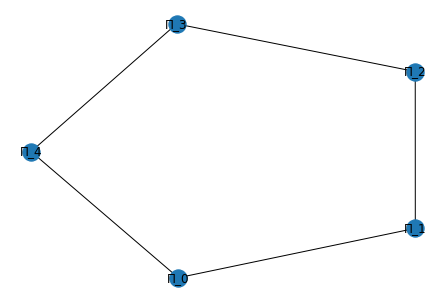

In [970]:
G = nx.Graph()

#node2 in G[node1] #yes if they are connected by an edge

G = nx.Graph()
G.add_nodes_from(L1)
G.add_edges_from([[L1[i],L1[(i+1)%(N)]] for i in range(N)])

#create a dictionary to simplify expressions later which sets projector products to zero
gDicts={}
for l1 in L1:
    for l2 in L1:
        if l1 in G[l2]:
            gDicts.update({l1*l2:sp.Integer(0)})


%matplotlib inline 
nx.draw(G, with_labels=True)

In [971]:
#Simplify objective using the orthogonality relations of the graph
#display(prune(objective).subs(gDicts))  

if(testType==1):
    #quick and dirty
    #because it won't be used
    objective_ = sp.expand(objective)
else:
    #treat it properly
    objective_ = sp.expand(prune(objective).subs(gDicts)).subs(gDicts).subs(sqDicts)

    #display(objective_)

In [972]:
Lx=[]

fileName="alphabetSave_testType_"+str(testType)+"_hDepth_"+str(hDepth)+"_lenL1_"+str(len(L1))

try:
    print("Loading from file")
    loadedThis=dill.load(open(fileName, "rb"))
    [Lx,L,L_]=loadedThis
    print("Done")
except:
    print("Failed to load")
    loadedThis=None

    
if (loadedThis==None):
    print("Evaluating")
    #This generates words of length n with each position holding any of the y letters
    def loop_rec(y, n=None, val=None):
        if n >= 1:
            for x in range(y):
                let=L1[x]
                if val == None:
                    newVal=let
                else:
                    newVal=let*val
                loop_rec(y, n - 1, newVal)
        else:
            #TODO: Find a better way of removing powers
            val_=val.subs(gDicts).subs(sqDicts).subs(sqDicts).subs(gDicts)
            if not val_ in Lx and val_ != 0 :
                Lx.append(val_)

    for i in range(2,hDepth+1):    
        #loop_rec(N,i)
        loop_rec(len(L1),i)


    L = I + L1 + Lx
    L_ = L1 + Lx

    dill.dump([Lx,L,L_], open(fileName, "wb"))
    print("Saved to disk")

    
print(L1)
if(len(Lx)<30):
    display(Lx)

Loading from file
Done
[Π_0, Π_1, Π_2, Π_3, Π_4]


In [973]:
#symbol to index dictionary
sTi={}

#The former should be obseleted gradually

sTr={}
sTc={}

for i in range(len(L)):
    sTc[L[i]]=i #for the column, the usual thing should work just as well
    sTr[conj(L[i])]=i #for the row it should be conjugated
    
    sTi[L[i]]=i

#print(sTi)

In [291]:
#print(iKCBS.eval_idealVal(Lx[3]),np.sqrt(1/5))

0.447213595499958*P 0.4472135954999579


In [974]:
print(Lx)

[Π_0, Π_2*Π_0, Π_3*Π_0, Π_1, Π_3*Π_1, Π_4*Π_1, Π_0*Π_2, Π_2, Π_4*Π_2, Π_0*Π_3, Π_1*Π_3, Π_3, Π_1*Π_4, Π_2*Π_4, Π_4, Π_0*Π_2*Π_0, Π_4*Π_2*Π_0, Π_0*Π_3*Π_0, Π_1*Π_3*Π_0, Π_0*Π_3*Π_1, Π_1*Π_3*Π_1, Π_1*Π_4*Π_1, Π_2*Π_4*Π_1, Π_2*Π_0*Π_2, Π_3*Π_0*Π_2, Π_1*Π_4*Π_2, Π_2*Π_4*Π_2, Π_2*Π_0*Π_3, Π_3*Π_0*Π_3, Π_3*Π_1*Π_3, Π_4*Π_1*Π_3, Π_3*Π_1*Π_4, Π_4*Π_1*Π_4, Π_0*Π_2*Π_4, Π_4*Π_2*Π_4]


In [975]:
#A function for directly extracting terms to construct indices

lI = I[0]


def lettersForExpr(termInSum):
    termInSum_ = pow_to_single_mul(termInSum) #sp.expand(pow_to_mul(termInSum))
    #print(termInSum_)
    #print(termInSum_.args)
    if(len(termInSum_.args[1:])<= hDepth  ): #if we can handle this using just the letters we produced
        lett = termInSum_.args[1]
        for lettInTerm in termInSum_.args[2:]:
            lett *= lettInTerm
        coeff = sp.N(termInSum_.args[0]) #In case we got symbolic square roots

        lett=lett.subs(sqDicts)            
        return[lett,lI,coeff]
        #eX = X[sTi[lett]][sTi[lI]]
        #y += coeff*eX

        #display(termInSum_)
        #display(lett) #These can be directly handled

    elif(len(termInSum_.args[1:])<= 2*hDepth ): #we can handle at most twice the letters            
        half=int(hDepth) +1
        #print(len(termInSum_.args[1:]),2*hDepth)
        #print(half)
        #print(termInSum_)
        lett1 = termInSum_.args[1]
        for lettInTerm in termInSum_.args[2:half]:
            lett1 *= lettInTerm
        lett2 = termInSum_.args[half]
        for lettInTerm in termInSum_.args[half+1:]:
            lett2 *= lettInTerm
        # display(termInSum_)
        # display(lett1) 
        # display(lett2)
        coeff = sp.N(termInSum_.args[0]) #In case we got symbolic square roots
        lett1=lett1.subs(sqDicts)
        lett2=lett2.subs(sqDicts)
        return [lett1,lett2,coeff]
        #eX = X[sTi[lett1]][sTi[lett2]]
        #y += coeff*eX
    else:
        print("objective not fully captured")           
        return ["objective not fully captured"]
        #flag="Objective not fully captured"
        #raise Warning("Increase hDepth: It looks like your objective is not captured by the current depth of the SDP heirarchy")


## Constraints from QM and Setting up SDP variables

In [976]:
ForceCalc=True
verbose=True
partialDisplay=False

hint=False #This will probably start working in a new version of cvxpy

fileName="lSave_4_testType_"+str(testType)+"_hDepth_"+str(hDepth)+"_lenL_"+str(len(L))

flags=["issues"]


ConstraintsThreshold = 10000 #Maximum number of constraints
useThreshold=False

try:
    print("Loading from file")
    loadedThis=dill.load(open(fileName, "rb"))
    [X,constraints]=loadedThis
    print("Done")
    print("SDP Size",X[0])
    print("Constrainst:", len(constraints))
except:
    loadedThis=None

 
    
    
if loadedThis==None or ForceCalc==True:
    print("Evaluating constraints")


    #L is the alphabet, to wit: it is the list of letters
    #
    X = cp.Variable((len(L),len(L)),symmetric=True)    

    #>> is for matrix inequality
    constraints = [X >> 0,X[sTi[lI],sTi[lI]]==1]


#     print("Adding constraints from the graph")
#     #Constraints from the graph (these come from single letters)        
#     for l1 in L1:
#         for l2 in L1:
#             eX = X[sTi[l1]][sTi[l2]] #picks the corresponding element from the variable matrix of the SDP library
#             if l1 in G[l2]:
#                 constraints += [eX == 0]

#     print("done")

    
    
    
    print("Adding constraints from Quantum Mechanics")
    
    tempCount=0
    dictTerms = {}
    halfLoop = 0
    #lettersUsed = []
    for l1 in L:
        print("Row of ",l1)
        if(tempCount>ConstraintsThreshold):
            break

        for l2 in L[halfLoop:]:
            term = l1*l2


            tS=[term]
            #display(term)
            for i in range(lDepth+1):
                tS.append(tS[-1].subs(sqDicts))
            simTerm=tS[-1]
            
            if(hint==True):                
                X[sTi[l1]][sTi[l2]].value=iKCBS.eval_idealVal(simTerm)
            
            #display(simTerm)
            #Orthogonality from the graph
            if simTerm.subs(gDicts)==sp.Integer(0):
                #print("I set ",l1,l2," to zero")
#                 display(l1)
#                 display(l2)
#                 display(simTerm.subs(gDicts))
                constraints += [ X[sTi[l1]][sTi[l2]] == 0 ]

            elif not(simTerm in dictTerms):
                dictTerms.update({simTerm:[l1,l2]})            
            else:
#                 l1_=dictTerms[simTerm][0]
#                 l2_=dictTerms[simTerm][1]
                [l1_,l2_]=dictTerms[simTerm]
                #I am not sure why the or part of this statement is reducing constraints
                
                if (not (l1==l1_ and l2==l2_) and not (l1==l2_ and l2==l1_)):                
                    
                    #print()
                    #if ((l1==l2_ and l2==l1_)):
#                         print("GOT ONE!")
#                         print("The ls")
#                         display(l1)
#                         display(l2)
                        
#                         print("The l_s")
#                         display(l1_)
#                         display(l2_)
                        
                    constraints += [ X[sTi[l1]][sTi[l2]] == X[sTi[l1_]][sTi[l2_]] ]
                    
                    tempCount+=1
                    
                    if(tempCount>ConstraintsThreshold and useThreshold==True):
                        break
                    
                    if(tempCount<10 or\
                       (100<tempCount and tempCount<110) or\
                       (1000<tempCount and tempCount<1010) or verbose):
                       
                        #print("Adding a new constraint")
                        print(l1,"*",l2,"=",l1_,"*",l2_)
                        try:
                            v1=iKCBS.eval_idealVal(l1*l2)
                            v2=iKCBS.eval_idealVal(l1_*l2_)                        
                            if(np.abs(v1 - v2)>1e-9): #1e-9):
                                print("Issue?")
                                print( v1, v2, np.abs(v1-v2) )
                        except:
                            pass
                            
                        #print("should be equal to",l1_,",",l2_)
                        if(partialDisplay):
                            print("l1")
                            display(l1)
                            print("l2")
                            display(l2)
                            print("l1_")
                            display(l1_)
                            print("l2_")
                            display(l2_)
                        
            del tS            
        halfLoop+=1

    print("done")

    print("Constraints", len(constraints))
    print("SDP", X[0])
    dill.dump([X,constraints], open(fileName, "wb"))
    print("Saved to disk")


try:
    del fileName
    del ForceCalc
except:
    print("Cleaned.")

Loading from file
Done
SDP Size var437520[0, 0:41]
Constrainst: 582
Evaluating constraints
Adding constraints from Quantum Mechanics
Row of  1
Row of  Π_0
Π_0 * Π_0 = 1 * Π_0
Π_0 * Π_2 = 1 * Π_0*Π_2
Π_0 * Π_3 = 1 * Π_0*Π_3
Π_0 * Π_0 = 1 * Π_0
Π_0 * Π_2*Π_0 = 1 * Π_0*Π_2*Π_0
Π_0 * Π_3*Π_0 = 1 * Π_0*Π_3*Π_0
Π_0 * Π_3*Π_1 = 1 * Π_0*Π_3*Π_1
Π_0 * Π_0*Π_2 = 1 * Π_0*Π_2
Π_0 * Π_2 = 1 * Π_0*Π_2
Π_0 * Π_0*Π_3 = 1 * Π_0*Π_3
Π_0 * Π_3 = 1 * Π_0*Π_3
Π_0 * Π_2*Π_4 = 1 * Π_0*Π_2*Π_4
Π_0 * Π_0*Π_2*Π_0 = 1 * Π_0*Π_2*Π_0
Π_0 * Π_0*Π_3*Π_0 = 1 * Π_0*Π_3*Π_0
Π_0 * Π_0*Π_3*Π_1 = 1 * Π_0*Π_3*Π_1
Π_0 * Π_0*Π_2*Π_4 = 1 * Π_0*Π_2*Π_4
Row of  Π_1
Π_1 * Π_1 = 1 * Π_1
Π_1 * Π_3 = 1 * Π_1*Π_3
Π_1 * Π_4 = 1 * Π_1*Π_4
Π_1 * Π_3*Π_0 = 1 * Π_1*Π_3*Π_0
Π_1 * Π_1 = 1 * Π_1
Π_1 * Π_3*Π_1 = 1 * Π_1*Π_3*Π_1
Π_1 * Π_4*Π_1 = 1 * Π_1*Π_4*Π_1
Π_1 * Π_4*Π_2 = 1 * Π_1*Π_4*Π_2
Π_1 * Π_1*Π_3 = 1 * Π_1*Π_3
Π_1 * Π_3 = 1 * Π_1*Π_3
Π_1 * Π_1*Π_4 = 1 * Π_1*Π_4
Π_1 * Π_4 = 1 * Π_1*Π_4
Π_1 * Π_1*Π_3*Π_0 = 1 * Π_1*Π_3*Π_0
Π_1 * Π_1*Π_3

Π_0*Π_3*Π_1 * Π_1*Π_4*Π_1 = Π_0*Π_3 * Π_1*Π_4*Π_1
Π_0*Π_3*Π_1 * Π_1*Π_4*Π_2 = Π_0*Π_3 * Π_1*Π_4*Π_2
Row of  Π_1*Π_3*Π_1
Π_1*Π_3*Π_1 * Π_1*Π_3*Π_1 = Π_1*Π_3 * Π_1*Π_3*Π_1
Π_1*Π_3*Π_1 * Π_1*Π_4*Π_1 = Π_1*Π_3 * Π_1*Π_4*Π_1
Π_1*Π_3*Π_1 * Π_1*Π_4*Π_2 = Π_1*Π_3 * Π_1*Π_4*Π_2
Row of  Π_1*Π_4*Π_1
Π_1*Π_4*Π_1 * Π_1*Π_4*Π_1 = Π_1*Π_4 * Π_1*Π_4*Π_1
Π_1*Π_4*Π_1 * Π_1*Π_4*Π_2 = Π_1*Π_4 * Π_1*Π_4*Π_2
Row of  Π_2*Π_4*Π_1
Π_2*Π_4*Π_1 * Π_1*Π_4*Π_2 = Π_2*Π_4 * Π_1*Π_4*Π_2
Row of  Π_2*Π_0*Π_2
Π_2*Π_0*Π_2 * Π_2*Π_0*Π_2 = Π_2*Π_0 * Π_2*Π_0*Π_2
Π_2*Π_0*Π_2 * Π_2*Π_4*Π_2 = Π_2*Π_0 * Π_2*Π_4*Π_2
Π_2*Π_0*Π_2 * Π_2*Π_0*Π_3 = Π_2*Π_0 * Π_2*Π_0*Π_3
Row of  Π_3*Π_0*Π_2
Π_3*Π_0*Π_2 * Π_2*Π_4*Π_2 = Π_3*Π_0 * Π_2*Π_4*Π_2
Π_3*Π_0*Π_2 * Π_2*Π_0*Π_3 = Π_3*Π_0 * Π_2*Π_0*Π_3
Row of  Π_1*Π_4*Π_2
Π_1*Π_4*Π_2 * Π_2*Π_4*Π_2 = Π_1*Π_4 * Π_2*Π_4*Π_2
Π_1*Π_4*Π_2 * Π_2*Π_0*Π_3 = Π_1*Π_4 * Π_2*Π_0*Π_3
Row of  Π_2*Π_4*Π_2
Π_2*Π_4*Π_2 * Π_2*Π_4*Π_2 = Π_2*Π_4 * Π_2*Π_4*Π_2
Π_2*Π_4*Π_2 * Π_2*Π_0*Π_3 = Π_2*Π_4 * Π_2*Π_0*Π_3
Row of  Π_

## Objective; Symbolic to SDP

In [977]:
#Objective function; symbolic to SDP constraints

# objective function evaluated (loop over product of all letters)
y = 0

if(testType==1):
    
    if(testSubType=="b"):
        print("Feasibilty test; objective=0")
    else:
        print("TEST: Constructing the KCBS expression instead of the Fidelity")
        len(L1)
        #print(L1[:1])
        for term in L1[:5]:
            display(term)
            y += X[sTi[lI]][sTi[term]]
        #y += 3*X[sTi[lI]][sTi[L1[2]]]    


else:

    print("Constructing the SDP objective from the symbolic objective") 
    for termInSum in objective_.args: #e.g. termInSum could look like a multiplication object with arguments (0.13,Π_4,Π_3) and so on    
        res = lettersForExpr(termInSum) #returns, e.g. [1.23,Π1,Π1]
        y += res[2] * X[sTi[res[0]]][sTi[res[1]]]
        del res

    
print("Done")


TEST: Constructing the KCBS expression instead of the Fidelity


Π₀

Π₁

Π₂

Π₃

Π₄

Done


In [217]:
#print(y)

## Localising Matrix Constraints

In [978]:
#Localising Matrix Constraints

M = []

printVerbose=False

if(hDepth>=3 and len(L1)>5):

    print("Localising matrix constraints...")


    for lett1 in I + L1:
        row = []
        for lett2 in I + L1:
            expr = sp.expand(lett1*iKCBS._T*lett2).subs(gDicts).subs(sqDicts).subs(gDicts).subs(sqDicts)
    #         print("the expression")
            if(printVerbose):
                display(expr)
            res = 0
            if expr != sp.Integer(0):
                #if there are many terms in the sum, sum over them
                if(isinstance(expr,sp.Add)):
                    for _ in expr.args:
    #                     print("Going in")
                        res_ = lettersForExpr(_)
    #                     print("printing res ")
    #                     print(res_)
                        __ = res_[2]*X[sTi[res_[0]]][sTi[res_[1]]]            
                        res += __ #this will contain something like 1.13*Π_1*Π_2 + 1.42*Π_1*Π_2
                #If it is just one term, compute directly
                else:
                    res_ = lettersForExpr(expr)
    #                 print("printing res ")
    #                 print(res_)
                    __ = res_[2]*X[sTi[res_[0]]][sTi[res_[1]]]            
                    res += __ #this will contain something like 1.13*Π_1*Π_2 + 1.42*Π_1*Π_2

            row.append(res) #this appends that calculation into the row
        M.append(row) #this appends the row into the list M

    lM = cp.bmat(M) #this converts the list M into a matrix which can be used to impose constraints in cvxpy


    locConstraints = [lM >> 0]

    del printVerbose
    print("Done. Size:",len(M))

In [219]:
#print(lM)

## Observed Constraints

In [979]:
#######################Constraints from the observations
obsConstraints=[]
print("Observed values; Adding constraints")

a=1/np.sqrt(5) -0.001
data = [a,a,a,a,a]

j=0
for l1 in L1[:5]:
    obsConstraints += [ X[sTi[l1],sTi[l1]] == data[j] ]
    j+=1
    
del j

print("Done.")
#print(obsConstraints)

Observed values; Adding constraints
Done.


## The SDP

In [980]:
def prettyX(X):
    X_=np.zeros((len(L),len(L)))
    i=0
    j=0
    for l1 in L:
        for l2 in L:
            X_[i][j]=X[sTi[l1]][sTi[l2]].value
            j+=1
        j=0
        i+=1
    return X_


def prettyPrint(X):
    y=pd.DataFrame(prettyX(X))
    print(y)

In [919]:
#Possible solvers
#MOSEK needs a license; will set it up later

#SCS
#CVXOPT
#MOSEK

verbose=True
currentConstraints = []

if(testType==0 or testType==2):    
    currentConstraints = constraints+obsConstraints 
    if(usePs==True):
        currentConstraints += locConstraints
elif(testType==1):
    currentConstraints = constraints
    if(testSubType=="b"):
        #y=0
        currentConstraints += obsConstraints
        

probMax = cp.Problem(cp.Maximize(y),currentConstraints)
probMin = cp.Problem(cp.Maximize(-y),currentConstraints)

#prob.solve()
#prob.solve(solver=cp.CVXOPT,verbose=True,**{'':ldl,'refinement':20,'show_progress':True,'feastol':10e-10,'reltol':10e-10,'abstol':10e-10})
try: 
    print("max:",probMax.solve(verbose=True,solver=cp.MOSEK))#,warm_start=True))#,eps=1e-5)) #,eps=1e-4))#,max_iters=100000))
    if(verbose):
        prettyPrint(X)        
except:
    print("max: Couldn't solve")
try:
    print("min:",-probMin.solve(verbose=True,solver=cp.MOSEK))#,warm_start=True))#,eps=1e-5)) #,eps=1e-4))#,max_iters=100000))
    if(verbose):
        prettyPrint(X)
except:
    print("min: Couldn't solve")
    
# del probMax
# del probMin
# del currentConstraints
# del obsConstraints



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2262            
  Cones                  : 0               
  Scalar variables       : 861             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2262            
  Cones                  : 0               
  Scalar variables       : 861             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer  - threads                : 20              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1681
Optimizer  - Cones                  : 1
Optimizer  - Scalar variable



Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2262            
  Cones                  : 0               
  Scalar variables       : 861             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2262            
  Cones                  : 0               
  Scalar variables       : 861             
  Matrix variables       : 1               
  Integer variables      : 0               

Optimizer  - threads                : 20              
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1681
Optimizer  - Cones                  : 1
Optimizer  - Scalar variable

In [ ]:
## Feeding in a guess
## https://www.cvxpy.org/tutorial/advanced/index.html#warm-start


#Ran the KCBS objective using MOSEK
#Ideal answer: 2.23606797749979

# 3 level
Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -2.0000000000e+00   nrm: 1e+00    Viol.  con: 4e-11    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -2.0000000000e+00   nrm: 2e+00    Viol.  con: 0e+00    var: 6e-13    barvar: 4e-11  
max: 1.999999999996969

# 2 level
Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -2.2359503404e+00   nrm: 1e+03    Viol.  con: 5e-08    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -2.2359351460e+00   nrm: 1e+02    Viol.  con: 0e+00    var: 9e-10    barvar: 1e-08  
max: 2.2359503404454824
    
# 1 level
Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -2.2360679847e+00   nrm: 1e+00    Viol.  con: 2e-09    var: 0e+00    barvar: 0e+00  
  Dual.    obj: -2.2360679851e+00   nrm: 2e+00    Viol.  con: 0e+00    var: 0e+00    barvar: 2e-09  
max: 2.2360679846809792
          0         1         2         3         4         5
0  1.000000  0.447214  0.447214  0.447214  0.447214  0.447214
1  0.447214  0.447214  0.000000  0.276393  0.276393  0.000000
2  0.447214  0.000000  0.447214  0.000000  0.276393  0.276393
3  0.447214  0.276393  0.000000  0.447214  0.000000  0.276393
4  0.447214  0.276393  0.276393  0.000000  0.447214  0.000000
5  0.447214  0.000000  0.276393  0.276393  0.000000  0.447214

In [58]:
#display(y)
print(np.sqrt(5))


#Level 2 (with P and Pd)
#2.2355706341820536
#precision: 4.4196e-06

#Level 2 (without P and Pd)
#2.2354232719751197
#precision: 2.8104e-06

#Level 2 (without P and Pd; )
#2.235475478232621
#precision: 1.1587e-05

#Level 2 (without P and Pd; innaccurate)
#2.2361588485516353

#2.233587365526617 (innaccurate with 100000 iterations)


#Level 1
#2.236062759267427
#precision: 1.3496e-05

2.23606797749979


In [238]:
#with the KCBS objective

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32509
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28886
Cones:	primal zero / dual free vars: 8786
	sd vars: 20100, sd blks: 1
Setup time: 1.59e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.74e+20  1.18e+21  1.00e+00 -3.91e+20  3.03e+21  4.38e+20  1.23e-01 
   100| 1.96e-02  3.27e-02  1.27e-03 -1.98e+00 -1.97e+00  1.27e-16  2.15e+00 
   200| 4.47e-03  7.05e-03  1.47e-04 -2.00e+00 -2.00e+00  3.40e-18  4.20e+00 
   300| 1.57e-03  2.48e-03  2.82e-05 -2.00e+00 -2.00e+00  8.47e-17  7.92e+00 
   400| 1.16e-03  1.69e-03  1.58e-05 -2.00e+00 -2.00e+00  2.60e-17  1.01e+01 
   500| 5.19e-04  8.41e-04  6.41e-06 -2.00e+00 -2.00e+00  1.29e-16  1.21e+01 
   600| 3.80e-04  6.69e-04  3.67e-06 -2.00e+00 -2.00e+00  2.17e-16  1.54e+01 
   700| 2.96e-04  4.85e-04  6.23e-07 -2.00e+00 -2.00e+00  6.50e-17  1.73e+01 
   800| 2.54e-04  4.20e-04  7.67e-07 -2.00e+00 -2.00e+00  6.47e-17  1.93e+01 
   900| 2.31e-04  4.08e-04  9.97e-07 -2.00e+00 -2.00e+00  1.85e-16  2.16e+01 
  1000| 2.06e-04  2.92e-04  6.33e-07 -2.00e+00 -2.00e+00  7.01e-17  2.45e+01 
  1100| 1.88e-04  2.71e-04  5.65e-07 -2.00e+00 -2.00e+00  8.40e-17  2.65e+01 
  1200| 1.21e-04  2.13e-04  3.31e-07 -2.00e+00 -2.00e+00  1.26e-16  2.85e+01 
  1300| 1.35e-04  2.36e-04  8.46e-07 -2.00e+00 -2.00e+00  4.05e-17  3.05e+01 
  1400| 1.76e-04  2.65e-04  9.41e-07 -2.00e+00 -2.00e+00  1.57e-16  3.31e+01 
  1500| 1.07e-04  1.76e-04  8.76e-07 -2.00e+00 -2.00e+00  2.35e-16  3.50e+01 
  1600| 8.77e-05  1.51e-04  9.50e-07 -2.00e+00 -2.00e+00  9.56e-18  3.70e+01 
  1700| 8.33e-05  1.36e-04  1.32e-06 -2.00e+00 -2.00e+00  9.63e-17  3.89e+01 
  1800| 6.80e-05  1.30e-04  9.47e-07 -2.00e+00 -2.00e+00  7.73e-17  4.32e+01 
  1900| 8.75e-05  1.36e-04  6.56e-07 -2.00e+00 -2.00e+00  1.89e-17  4.51e+01 
  1920| 4.29e-05  9.10e-05  4.67e-07 -2.00e+00 -2.00e+00  1.13e-16  4.55e+01 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.55e+01s
	Lin-sys: nnz in L factor: 81982, avg solve time: 5.65e-04s
	Cones: avg projection time: 1.72e-02s
	Acceleration: avg step time: 4.28e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.3687e-09, dist(y, K*) = 1.9232e-09, s'y/|s||y| = 9.6521e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 4.2888e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.1003e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 4.6699e-07
----------------------------------------------------------------------------
c'x = -2.0000, -b'y = -2.0000
============================================================================
max: 1.9999896500571939
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32509
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28886
Cones:	primal zero / dual free vars: 8786
	sd vars: 20100, sd blks: 1
Setup time: 6.17e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 3.85e+20  1.23e+21  1.00e+00 -3.91e+20  3.03e+21  4.38e+20  6.41e-02 
   100| 4.22e-04  6.80e-04  2.80e-04 -1.65e-04 -4.45e-04  1.81e-16  2.40e+00 
   200| 6.23e-05  9.31e-05  9.41e-06 -4.20e-06 -1.36e-05  9.97e-17  4.20e+00 
----------------------------------------------------------------------------
Status: Solved
Timing: Solve time: 4.20e+00s
	Lin-sys: nnz in L factor: 81982, avg solve time: 6.05e-04s
	Cones: avg projection time: 1.44e-02s
	Acceleration: avg step time: 4.03e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.6395e-09, dist(y, K*) = 3.7961e-09, s'y/|s||y| = 2.4415e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 6.2330e-05
dual res:   |A'y + c|_2 / (1 + |c|_2) = 9.3066e-05
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 9.4093e-06
----------------------------------------------------------------------------
c'x = -0.0000, -b'y = -0.0000
============================================================================
min: -4.195886103499908e-06

In [ ]:
# For the full objective

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32752
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28926
Cones:	primal zero / dual free vars: 8790
	sd vars: 20136, sd blks: 2
Setup time: 1.91e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.77e+20  9.64e+20  1.00e+00 -4.48e+22  1.34e+23  3.97e+22  6.65e-02 
   100| 4.52e-02  6.79e-02  1.78e-02 -7.59e+00 -7.30e+00  4.55e-15  2.17e+00 
   200| 2.37e-02  3.50e-02  1.74e-03 -1.07e+01 -1.06e+01  6.74e-15  4.48e+00 
   300| 1.25e-02  2.05e-02  1.11e-03 -1.22e+01 -1.21e+01  1.51e-15  7.43e+00 
   400| 1.80e-02  2.89e-02  1.66e-03 -1.28e+01 -1.29e+01  1.89e-15  9.58e+00 
   500| 1.08e-02  1.82e-02  1.96e-03 -1.32e+01 -1.31e+01  5.36e-16  1.18e+01 
   600| 1.69e-02  2.81e-02  1.72e-03 -1.37e+01 -1.36e+01  6.61e-15  1.38e+01 
   700| 1.14e-02  1.74e-02  3.12e-04 -1.42e+01 -1.42e+01  1.40e-15  1.68e+01 
   800| 1.29e-02  2.07e-02  6.06e-04 -1.47e+01 -1.47e+01  7.84e-16  1.91e+01 
   900| 1.23e-02  1.86e-02  1.43e-03 -1.51e+01 -1.50e+01  6.43e-15  2.12e+01 
  1000| 1.47e-02  2.56e-02  3.74e-05 -1.55e+01 -1.55e+01  8.07e-16  2.32e+01 
  1100| 1.12e-02  1.70e-02  1.81e-03 -1.62e+01 -1.62e+01  3.88e-15  2.53e+01 
  1200| 1.52e-02  2.80e-02  6.11e-04 -1.63e+01 -1.63e+01  9.76e-15  2.79e+01 
  1300| 1.21e-02  2.15e-02  9.02e-04 -1.67e+01 -1.67e+01  5.30e-15  3.00e+01 
  1400| 1.21e-02  1.83e-02  1.29e-03 -1.71e+01 -1.71e+01  1.60e-15  3.19e+01 
  1500| 1.15e-02  1.92e-02  7.87e-04 -1.76e+01 -1.76e+01  4.74e-15  3.40e+01 
  1600| 1.12e-02  1.71e-02  2.19e-04 -1.80e+01 -1.81e+01  1.86e-15  3.61e+01 
  1700| 1.17e-02  1.84e-02  1.01e-03 -1.85e+01 -1.85e+01  4.00e-15  3.81e+01 
  1800| 1.24e-02  1.98e-02  3.06e-04 -1.88e+01 -1.88e+01  1.05e-15  4.09e+01 
  1900| 1.16e-02  1.74e-02  1.08e-03 -1.92e+01 -1.92e+01  9.57e-16  4.33e+01 
  2000| 1.23e-02  1.88e-02  1.44e-04 -1.96e+01 -1.96e+01  5.49e-16  4.53e+01 
  2100| 9.58e-03  1.61e-02  5.72e-04 -2.00e+01 -1.99e+01  9.35e-15  4.74e+01 
  2200| 1.19e-02  2.09e-02  2.27e-04 -2.03e+01 -2.03e+01  3.03e-15  4.94e+01 
  2300| 1.37e-02  2.94e-02  4.18e-04 -2.07e+01 -2.07e+01  4.78e-15  5.13e+01 
  2400| 1.25e-02  3.00e-02  4.54e-04 -2.14e+01 -2.14e+01  9.48e-15  5.33e+01 
  2500| 1.54e-02  2.50e-02  9.22e-04 -2.20e+01 -2.20e+01  6.35e-15  5.53e+01 
  2600| 1.54e-02  3.58e-02  4.85e-04 -2.23e+01 -2.24e+01  7.75e-15  5.74e+01 
  2700| 1.27e-02  3.29e-02  7.17e-04 -2.28e+01 -2.27e+01  1.01e-14  5.94e+01 
  2800| 1.14e-02  1.99e-02  1.52e-03 -2.31e+01 -2.30e+01  6.04e-16  6.14e+01 
  2900| 1.39e-02  3.46e-02  1.88e-03 -2.34e+01 -2.34e+01  1.68e-15  6.34e+01 
  3000| 1.15e-02  2.91e-02  1.27e-03 -2.37e+01 -2.37e+01  2.72e-15  6.55e+01 
  3100| 1.29e-02  2.87e-02  8.86e-04 -2.43e+01 -2.43e+01  3.60e-15  6.81e+01 
  3200| 1.19e-02  2.64e-02  8.26e-04 -2.52e+01 -2.52e+01  3.31e-15  7.05e+01 
  3300| 1.29e-02  3.66e-02  1.24e-03 -2.55e+01 -2.56e+01  2.59e-15  7.26e+01 
  3400| 1.18e-02  3.56e-02  1.25e-03 -2.57e+01 -2.58e+01  2.07e-16  7.46e+01 
  3500| 1.44e-02  3.75e-02  4.98e-04 -2.64e+01 -2.64e+01  9.20e-16  7.66e+01 
  3600| 1.23e-02  2.11e-02  1.32e-03 -2.63e+01 -2.62e+01  9.79e-15  8.00e+01 
  3700| 1.24e-02  3.96e-02  1.39e-04 -2.70e+01 -2.70e+01  1.06e-14  8.22e+01 
  3800| 1.21e-02  3.74e-02  1.29e-03 -2.77e+01 -2.78e+01  2.57e-16  8.42e+01 
  3900| 1.12e-02  2.29e-02  3.52e-04 -2.76e+01 -2.76e+01  3.74e-15  8.62e+01 
  4000| 8.80e-03  2.52e-02  7.40e-04 -2.82e+01 -2.81e+01  2.60e-15  8.93e+01 
  4100| 1.08e-02  3.73e-02  8.26e-04 -2.88e+01 -2.87e+01  1.10e-14  9.17e+01 
  4200| 9.98e-03  2.47e-02  2.39e-04 -2.91e+01 -2.91e+01  6.77e-15  9.40e+01 
  4300| 1.10e-02  1.85e-02  4.60e-04 -2.97e+01 -2.97e+01  6.90e-15  9.62e+01 
  4400| 7.58e-03  2.16e-02  6.87e-04 -3.00e+01 -3.00e+01  2.32e-15  9.87e+01 
  4500| 1.14e-02  2.28e-02  1.31e-03 -3.05e+01 -3.06e+01  8.43e-15  1.01e+02 
  4600| 9.47e-03  2.88e-02  6.01e-04 -3.08e+01 -3.09e+01  3.38e-17  1.03e+02 
  4700| 8.94e-03  2.85e-02  1.56e-03 -3.12e+01 -3.13e+01  3.61e-15  1.05e+02 
  4800| 8.94e-03  2.73e-02  1.12e-03 -3.16e+01 -3.17e+01  1.27e-15  1.08e+02 
  4900| 7.22e-03  2.15e-02  6.84e-05 -3.19e+01 -3.19e+01  1.27e-16  1.10e+02 
  5000| 9.27e-03  3.23e-02  2.20e-03 -3.23e+01 -3.25e+01  3.07e-15  1.12e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 1.12e+02s
	Lin-sys: nnz in L factor: 82376, avg solve time: 5.90e-04s
	Cones: avg projection time: 1.59e-02s
	Acceleration: avg step time: 4.23e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0711e-09, dist(y, K*) = 2.2428e-09, s'y/|s||y| = 1.3955e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 9.2666e-03
dual res:   |A'y + c|_2 / (1 + |c|_2) = 3.2285e-02
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 2.1992e-03
----------------------------------------------------------------------------
c'x = -32.3212, -b'y = -32.4659
============================================================================
max: 32.32118633353611
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32752
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28926
Cones:	primal zero / dual free vars: 8790
	sd vars: 20136, sd blks: 2
Setup time: 5.59e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.20e+20  1.62e+21  1.00e+00 -4.44e+22  1.34e+23  3.97e+22  1.82e-01 
   100| 6.40e-02  1.01e-01  2.21e-02  4.30e+00  4.52e+00  8.84e-15  3.56e+00 
   200| 3.01e-02  3.81e-02  1.19e-03  2.88e+00  2.87e+00  4.02e-15  5.56e+00 
   300| 1.63e-02  2.46e-02  2.20e-02  1.86e+00  1.96e+00  2.10e-15  7.51e+00 
   400| 1.43e-02  2.24e-02  9.53e-03  9.72e-01  9.44e-01  9.73e-15  1.15e+01 
   500| 1.48e-02  2.17e-02  3.71e-02  3.18e-01  3.81e-01  7.18e-15  1.34e+01 
   600| 1.26e-02  2.20e-02  5.56e-02 -1.69e-01 -9.85e-02  1.15e-14  1.54e+01 
   700| 1.28e-02  1.97e-02  2.13e-02 -8.92e-01 -8.33e-01  4.32e-15  1.76e+01 
   800| 1.49e-02  2.34e-02  2.58e-04 -1.17e+00 -1.17e+00  5.47e-15  2.25e+01 
   900| 1.34e-02  2.71e-02  4.19e-03 -1.85e+00 -1.83e+00  1.74e-15  2.45e+01 
  1000| 1.40e-02  2.39e-02  1.33e-02 -2.21e+00 -2.28e+00  2.44e-15  2.66e+01 
  1100| 1.26e-02  1.98e-02  9.30e-03 -2.77e+00 -2.83e+00  1.02e-14  2.86e+01 
  1200| 1.43e-02  2.85e-02  5.77e-03 -3.07e+00 -3.03e+00  4.14e-16  3.15e+01 
  1300| 1.41e-02  2.70e-02  8.28e-03 -3.55e+00 -3.49e+00  2.99e-15  3.35e+01 
  1400| 1.22e-02  2.51e-02  6.69e-03 -3.96e+00 -4.02e+00  2.02e-15  3.61e+01 
  1500| 1.30e-02  3.33e-02  1.55e-02 -4.49e+00 -4.65e+00  5.60e-16  3.81e+01 
  1600| 1.52e-02  3.92e-02  1.49e-02 -4.94e+00 -5.10e+00  3.45e-15  4.02e+01 
  1700| 1.68e-02  3.51e-02  1.44e-03 -5.23e+00 -5.22e+00  4.43e-15  4.26e+01 
  1800| 1.32e-02  2.49e-02  5.88e-03 -5.64e+00 -5.56e+00  8.01e-15  4.46e+01 
  1900| 1.30e-02  2.12e-02  8.81e-03 -6.01e+00 -5.90e+00  1.58e-15  4.68e+01 
  2000| 1.15e-02  2.50e-02  4.95e-03 -6.58e+00 -6.65e+00  1.22e-15  4.89e+01 
  2100| 1.17e-02  2.24e-02  2.96e-03 -7.12e+00 -7.07e+00  5.56e-15  5.09e+01 
  2200| 1.21e-02  2.58e-02  1.00e-03 -7.62e+00 -7.60e+00  3.50e-15  5.30e+01 
  2300| 1.13e-02  3.40e-02  3.38e-03 -8.10e+00 -8.16e+00  4.82e-15  5.53e+01 

  2400| 1.14e-02  3.63e-02  2.29e-03 -8.53e+00 -8.49e+00  3.04e-15  5.73e+01 
  2500| 8.23e-03  2.98e-02  9.19e-04 -9.06e+00 -9.07e+00  4.98e-16  5.92e+01 
  2600| 1.10e-02  4.08e-02  1.72e-03 -9.59e+00 -9.62e+00  4.82e-15  6.12e+01 
  2700| 1.26e-02  3.70e-02  3.40e-03 -9.99e+00 -1.01e+01  1.77e-15  6.40e+01 
  2800| 9.52e-03  2.92e-02  1.66e-03 -1.05e+01 -1.04e+01  5.18e-15  6.61e+01 
  2900| 1.09e-02  2.77e-02  2.99e-04 -1.09e+01 -1.09e+01  4.13e-16  6.83e+01 
  3000| 1.40e-02  3.44e-02  3.13e-04 -1.13e+01 -1.13e+01  4.21e-15  7.02e+01 
  3100| 1.38e-02  3.36e-02  1.33e-03 -1.20e+01 -1.20e+01  5.33e-15  7.21e+01 
  3200| 1.40e-02  2.84e-02  3.76e-03 -1.24e+01 -1.23e+01  3.01e-15  7.42e+01 
  3300| 1.37e-02  2.57e-02  2.00e-04 -1.31e+01 -1.31e+01  4.28e-15  7.65e+01 
  3400| 1.35e-02  2.26e-02  2.79e-03 -1.35e+01 -1.36e+01  3.84e-15  7.85e+01 
  3500| 1.30e-02  2.60e-02  2.15e-03 -1.38e+01 -1.38e+01  3.14e-15  8.05e+01 
  3600| 1.31e-02  2.30e-02  2.52e-03 -1.41e+01 -1.41e+01  3.68e-15  8.27e+01 
  3700| 1.35e-02  3.18e-02  2.09e-03 -1.47e+01 -1.47e+01  8.01e-15  8.52e+01 
  3800| 1.17e-02  2.85e-02  7.12e-04 -1.52e+01 -1.52e+01  5.69e-15  8.78e+01 
  3900| 1.25e-02  3.52e-02  4.43e-04 -1.56e+01 -1.56e+01  1.18e-15  8.99e+01 
  4000| 8.96e-03  2.87e-02  1.24e-03 -1.58e+01 -1.59e+01  1.34e-15  9.19e+01 
  4100| 8.84e-03  2.85e-02  4.10e-03 -1.61e+01 -1.59e+01  3.79e-15  9.41e+01 
  4200| 8.29e-03  2.48e-02  2.78e-03 -1.64e+01 -1.64e+01  2.63e-15  9.86e+01 
  4300| 8.59e-03  2.18e-02  7.48e-04 -1.69e+01 -1.69e+01  1.93e-15  1.01e+02 
  4400| 1.03e-02  2.06e-02  3.96e-03 -1.72e+01 -1.70e+01  7.90e-16  1.03e+02 
  4500| 9.20e-03  1.59e-02  1.69e-03 -1.76e+01 -1.75e+01  4.20e-16  1.06e+02 
  4600| 1.05e-02  1.75e-02  2.26e-03 -1.79e+01 -1.80e+01  3.07e-15  1.08e+02 
  4700| 1.18e-02  2.07e-02  4.14e-03 -1.82e+01 -1.80e+01  1.76e-15  1.10e+02 
  4800| 8.50e-03  1.63e-02  7.38e-04 -1.85e+01 -1.85e+01  1.17e-15  1.12e+02 
  4900| 8.76e-03  1.82e-02  1.22e-03 -1.89e+01 -1.90e+01  1.00e-15  1.14e+02 
  5000| 1.08e-02  2.55e-02  3.18e-03 -1.92e+01 -1.90e+01  6.28e-16  1.16e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 1.16e+02s
	Lin-sys: nnz in L factor: 82376, avg solve time: 5.90e-04s
	Cones: avg projection time: 1.66e-02s
	Acceleration: avg step time: 4.19e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.4824e-09, dist(y, K*) = 2.3231e-09, s'y/|s||y| = -3.7268e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 1.0830e-02
dual res:   |A'y + c|_2 / (1 + |c|_2) = 2.5510e-02
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.1806e-03
----------------------------------------------------------------------------
c'x = -19.1557, -b'y = -19.0311
============================================================================
min: -19.15570043945181


In [ ]:
# For state only

----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32752
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28926
Cones:	primal zero / dual free vars: 8790
	sd vars: 20136, sd blks: 2
Setup time: 4.50e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.52e+20  1.23e+21  1.00e+00 -2.51e+21  1.46e+22  2.53e+21  6.46e-02 
   100| 6.25e-02  1.11e-01  1.58e-03 -7.30e-01 -7.34e-01  3.27e-16  2.99e+00 
   200| 2.33e-02  3.63e-02  2.10e-03 -9.08e-01 -9.14e-01  2.48e-16  4.99e+00 
   300| 1.26e-02  2.26e-02  1.14e-03 -1.05e+00 -1.05e+00  3.83e-16  7.39e+00 
   400| 3.17e-02  4.94e-02  3.39e-04 -1.14e+00 -1.14e+00  7.27e-16  9.78e+00 
   500| 9.63e-03  1.85e-02  8.86e-04 -1.22e+00 -1.21e+00  4.45e-17  1.24e+01 
   600| 1.51e-02  2.31e-02  1.47e-03 -1.29e+00 -1.30e+00  9.95e-16  1.48e+01 
   700| 1.46e-02  2.47e-02  8.25e-04 -1.36e+00 -1.36e+00  3.13e-16  1.72e+01 
   800| 1.70e-02  2.80e-02  4.80e-04 -1.40e+00 -1.39e+00  1.20e-15  2.09e+01 
   900| 8.78e-03  1.57e-02  6.14e-04 -1.43e+00 -1.43e+00  1.77e-16  2.29e+01 
  1000| 1.99e-02  3.14e-02  9.00e-04 -1.45e+00 -1.45e+00  2.57e-16  2.50e+01 
  1100| 1.18e-02  1.86e-02  1.32e-04 -1.47e+00 -1.47e+00  8.41e-16  2.72e+01 
  1200| 1.60e-02  3.43e-02  9.09e-04 -1.48e+00 -1.48e+00  1.15e-15  2.92e+01 
  1300| 1.39e-02  3.04e-02  1.39e-03 -1.48e+00 -1.48e+00  6.05e-16  3.12e+01 
  1400| 1.69e-02  2.60e-02  2.14e-03 -1.49e+00 -1.50e+00  9.84e-17  3.33e+01 
  1500| 1.24e-02  1.98e-02  1.32e-04 -1.49e+00 -1.49e+00  4.53e-16  3.52e+01 
  1600| 1.30e-02  2.67e-02  8.96e-04 -1.49e+00 -1.49e+00  7.91e-16  3.73e+01 
  1700| 1.08e-02  2.27e-02  5.61e-04 -1.50e+00 -1.50e+00  1.13e-16  3.94e+01 
  1800| 9.01e-03  1.39e-02  2.35e-04 -1.50e+00 -1.50e+00  1.51e-16  4.22e+01 
  1900| 9.19e-03  1.84e-02  5.20e-04 -1.51e+00 -1.50e+00  1.25e-15  4.42e+01 
  2000| 1.04e-02  2.00e-02  3.16e-04 -1.51e+00 -1.51e+00  8.69e-16  4.66e+01 
  2100| 9.84e-03  2.08e-02  2.04e-05 -1.50e+00 -1.51e+00  3.68e-16  4.86e+01 
  2200| 7.54e-03  1.38e-02  1.96e-04 -1.51e+00 -1.51e+00  7.38e-16  5.06e+01 
  2300| 9.45e-03  1.56e-02  3.86e-04 -1.51e+00 -1.52e+00  5.66e-16  5.25e+01 
  2400| 1.11e-02  2.58e-02  9.62e-04 -1.51e+00 -1.51e+00  2.05e-16  5.45e+01 
  2500| 1.10e-02  2.29e-02  1.09e-03 -1.52e+00 -1.51e+00  1.11e-17  5.65e+01 
  2600| 1.06e-02  2.68e-02  2.25e-04 -1.52e+00 -1.52e+00  2.07e-19  5.85e+01 
  2700| 9.98e-03  2.00e-02  6.74e-04 -1.52e+00 -1.52e+00  5.98e-16  6.05e+01 
  2800| 1.13e-02  1.97e-02  3.14e-04 -1.52e+00 -1.52e+00  7.25e-16  6.30e+01 
  2900| 1.24e-02  3.03e-02  3.40e-04 -1.52e+00 -1.52e+00  4.76e-16  6.52e+01 
  3000| 1.33e-02  2.44e-02  4.75e-04 -1.52e+00 -1.52e+00  1.17e-16  6.73e+01 
  3100| 1.15e-02  2.49e-02  4.85e-04 -1.52e+00 -1.52e+00  3.71e-16  6.93e+01 
  3200| 8.19e-03  1.92e-02  5.14e-05 -1.53e+00 -1.53e+00  2.41e-16  7.12e+01 
  3300| 1.05e-02  1.55e-02  3.45e-05 -1.53e+00 -1.53e+00  2.44e-16  7.32e+01 
  3400| 1.19e-02  2.79e-02  2.22e-04 -1.53e+00 -1.53e+00  8.50e-17  7.51e+01 
  3500| 9.50e-03  2.40e-02  1.71e-04 -1.53e+00 -1.53e+00  1.69e-16  7.70e+01 
  3600| 9.22e-03  1.49e-02  3.48e-04 -1.53e+00 -1.53e+00  4.96e-16  7.91e+01 
  3700| 8.60e-03  2.02e-02  1.90e-04 -1.53e+00 -1.53e+00  1.82e-16  8.12e+01 
  3800| 9.93e-03  2.32e-02  7.32e-04 -1.53e+00 -1.53e+00  3.70e-17  8.32e+01 
  3900| 7.39e-03  1.15e-02  4.35e-04 -1.54e+00 -1.53e+00  5.20e-16  8.51e+01 
  4000| 7.22e-03  1.64e-02  3.69e-05 -1.54e+00 -1.54e+00  2.15e-16  8.71e+01 
  4100| 7.71e-03  1.80e-02  3.16e-05 -1.54e+00 -1.54e+00  2.15e-16  8.91e+01 
  4200| 6.06e-03  1.01e-02  2.12e-04 -1.54e+00 -1.54e+00  1.53e-16  9.11e+01 
  4300| 6.79e-03  1.76e-02  3.17e-04 -1.54e+00 -1.54e+00  2.16e-17  9.36e+01 
  4400| 7.79e-03  1.48e-02  3.47e-05 -1.54e+00 -1.54e+00  5.50e-16  9.59e+01 
  4500| 6.08e-03  1.29e-02  6.11e-05 -1.54e+00 -1.54e+00  8.49e-16  9.79e+01 
  4600| 9.26e-03  1.76e-02  3.05e-04 -1.54e+00 -1.54e+00  6.74e-17  9.99e+01 
  4700| 6.29e-03  1.69e-02  2.46e-04 -1.55e+00 -1.55e+00  2.76e-16  1.02e+02 
  4800| 7.44e-03  1.18e-02  7.06e-04 -1.55e+00 -1.55e+00  8.34e-17  1.04e+02 
  4900| 6.09e-03  1.60e-02  1.42e-04 -1.55e+00 -1.55e+00  8.27e-16  1.06e+02 
  5000| 5.96e-03  1.11e-02  3.36e-04 -1.55e+00 -1.54e+00  2.90e-16  1.08e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 1.08e+02s
	Lin-sys: nnz in L factor: 82376, avg solve time: 5.69e-04s
	Cones: avg projection time: 1.53e-02s
	Acceleration: avg step time: 4.05e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 2.0998e-09, dist(y, K*) = 2.2513e-09, s'y/|s||y| = -2.1836e-13
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.9555e-03
dual res:   |A'y + c|_2 / (1 + |c|_2) = 1.1071e-02
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 3.3577e-04
----------------------------------------------------------------------------
c'x = -1.5459, -b'y = -1.5445
============================================================================
max: 1.5459193675310419
----------------------------------------------------------------------------
	SCS v2.1.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 32752
eps = 1.00e-04, alpha = 1.50, max_iters = 5000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 20100, constraints m = 28926
Cones:	primal zero / dual free vars: 8790
	sd vars: 20136, sd blks: 2
Setup time: 3.85e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.66e+20  1.52e+21  1.00e+00 -2.43e+21  1.47e+22  2.53e+21  8.51e-02 
   100| 6.85e-02  1.04e-01  4.00e-02  6.14e-01  7.07e-01  1.45e-16  2.68e+00 
   200| 2.52e-02  3.57e-02  4.47e-04  4.88e-01  4.87e-01  6.71e-17  5.04e+00 
   300| 1.47e-02  2.16e-02  1.99e-03  4.06e-01  4.02e-01  2.70e-16  7.11e+00 
   400| 1.53e-02  2.26e-02  2.19e-03  3.25e-01  3.22e-01  4.04e-16  9.01e+00 
   500| 1.55e-02  2.48e-02  2.63e-03  2.50e-01  2.54e-01  7.56e-16  1.12e+01 
   600| 1.56e-02  2.32e-02  1.02e-03  1.73e-01  1.75e-01  7.56e-16  1.32e+01 
   700| 1.12e-02  1.95e-02  6.73e-03  1.13e-01  1.05e-01  3.96e-16  1.62e+01 
   800| 1.24e-02  2.14e-02  7.24e-03  6.93e-02  7.76e-02  1.07e-16  1.85e+01 
   900| 1.42e-02  2.55e-02  1.95e-03  4.52e-02  4.30e-02  2.17e-16  2.07e+01 
  1000| 1.30e-02  2.33e-02  1.69e-03  2.46e-02  2.29e-02  4.90e-16  2.44e+01 
  1100| 9.15e-03  1.52e-02  6.14e-03  1.58e-02  9.50e-03  4.25e-16  2.66e+01 
  1200| 1.09e-02  1.86e-02  1.52e-02  5.93e-03 -9.51e-03  1.43e-16  2.88e+01 
  1300| 8.17e-03  1.22e-02  1.57e-03  3.70e-03  2.12e-03  8.87e-16  3.10e+01 
  1400| 1.17e-02  1.79e-02  1.03e-02  4.98e-03  1.55e-02  2.09e-16  3.30e+01 
  1500| 9.03e-03  1.47e-02  5.89e-03  3.16e-03  9.12e-03  9.94e-17  3.49e+01 
  1600| 8.99e-03  1.57e-02  1.15e-02  9.75e-04  1.26e-02  1.17e-15  3.72e+01 
  1700| 9.48e-03  1.37e-02  6.99e-03 -4.38e-03  2.66e-03  2.80e-16  3.97e+01 
  1800| 8.51e-03  1.40e-02  1.39e-03 -1.04e-02 -1.18e-02  2.51e-16  4.25e+01 
  1900| 9.57e-03  1.57e-02  3.32e-03 -1.44e-02 -1.78e-02  4.70e-16  4.45e+01 
  2000| 8.61e-03  1.18e-02  4.78e-03 -1.32e-02 -8.27e-03  5.89e-16  4.66e+01 
  2100| 6.21e-03  9.29e-03  6.58e-03 -1.35e-02 -6.79e-03  4.33e-16  4.87e+01 
  2200| 8.70e-03  1.32e-02  6.27e-03 -2.01e-02 -2.66e-02  1.40e-15  5.11e+01 
  2300| 7.56e-03  1.20e-02  3.64e-03 -2.13e-02 -2.52e-02  1.38e-15  5.31e+01 
  2400| 5.89e-03  1.06e-02  6.29e-03 -2.32e-02 -2.98e-02  1.95e-16  5.51e+01 
  2500| 5.96e-03  9.36e-03  5.42e-03 -2.57e-02 -3.15e-02  5.32e-16  5.71e+01 
  2600| 8.32e-03  1.51e-02  5.83e-03 -2.67e-02 -3.28e-02  1.03e-15  5.98e+01 
  2700| 5.95e-03  9.28e-03  4.27e-04 -2.63e-02 -2.67e-02  6.46e-16  6.23e+01 
  2800| 5.79e-03  9.66e-03  3.91e-04 -2.72e-02 -2.68e-02  4.78e-17  6.45e+01 
  2900| 5.53e-03  1.13e-02  8.46e-03 -2.55e-02 -1.66e-02  2.33e-16  6.69e+01 
  3000| 7.59e-03  1.23e-02  6.12e-04 -3.28e-02 -3.34e-02  3.42e-16  7.07e+01 
  3100| 4.51e-03  7.10e-03  1.93e-03 -3.31e-02 -3.52e-02  4.94e-16  7.29e+01 
  3200| 4.80e-03  8.74e-03  4.11e-03 -3.13e-02 -2.69e-02  4.23e-16  7.48e+01 
  3300| 5.07e-03  7.79e-03  5.45e-03 -3.59e-02 -4.18e-02  2.62e-16  7.68e+01 
  3400| 4.96e-03  7.50e-03  1.13e-03 -3.54e-02 -3.42e-02  2.51e-16  7.86e+01 
  3500| 5.71e-03  7.56e-03  3.37e-03 -3.54e-02 -3.18e-02  2.48e-16  8.06e+01 
  3600| 5.35e-03  8.96e-03  8.96e-04 -3.87e-02 -3.97e-02  3.28e-17  8.31e+01 
  3700| 4.52e-03  6.74e-03  4.52e-03 -3.81e-02 -3.32e-02  3.06e-16  8.53e+01 
  3800| 4.85e-03  8.24e-03  2.58e-03 -4.18e-02 -4.46e-02  1.06e-17  8.73e+01 
  3900| 3.77e-03  7.50e-03  2.11e-03 -3.96e-02 -3.73e-02  2.12e-16  8.92e+01 
  4000| 4.84e-03  7.97e-03  1.11e-03 -4.34e-02 -4.46e-02  1.42e-16  9.11e+01 
  4100| 5.13e-03  8.34e-03  1.25e-03 -4.38e-02 -4.51e-02  4.42e-16  9.30e+01 
  4200| 5.44e-03  9.19e-03  3.20e-04 -4.47e-02 -4.43e-02  5.08e-17  9.49e+01 
  4300| 4.31e-03  6.69e-03  2.11e-04 -4.61e-02 -4.59e-02  5.28e-16  9.68e+01 
  4400| 5.24e-03  8.41e-03  4.20e-04 -4.55e-02 -4.50e-02  7.03e-16  9.89e+01 
  4500| 4.32e-03  6.20e-03  3.58e-03 -4.82e-02 -5.22e-02  8.49e-17  1.01e+02 
  4600| 4.04e-03  6.68e-03  2.93e-03 -4.76e-02 -4.44e-02  4.00e-16  1.05e+02 
  4700| 4.33e-03  6.95e-03  8.30e-04 -5.07e-02 -5.17e-02  3.76e-16  1.07e+02 
  4800| 3.48e-03  5.48e-03  1.62e-03 -5.05e-02 -4.87e-02  5.41e-16  1.09e+02 
  4900| 5.88e-03  1.03e-02  1.16e-03 -5.21e-02 -5.34e-02  7.47e-16  1.11e+02 
  5000| 5.02e-03  7.68e-03  1.81e-03 -5.22e-02 -5.02e-02  4.36e-16  1.13e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 1.13e+02s
	Lin-sys: nnz in L factor: 82376, avg solve time: 5.89e-04s
	Cones: avg projection time: 1.61e-02s
	Acceleration: avg step time: 4.14e-03s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 1.2425e-09, dist(y, K*) = 1.3660e-09, s'y/|s||y| = 1.1947e-12
primal res: |Ax + s - b|_2 / (1 + |b|_2) = 5.0161e-03
dual res:   |A'y + c|_2 / (1 + |c|_2) = 7.6756e-03
rel gap:    |c'x + b'y| / (1 + |c'x| + |b'y|) = 1.8062e-03
----------------------------------------------------------------------------
c'x = -0.0522, -b'y = -0.0502
============================================================================
min: -0.0522061928831998